In [1]:
from collections import Counter
import random
import os

from medmnist.dataset import OrganAMNIST
from torch.utils.data import DataLoader
from torchvision import transforms
import chart_studio.plotly as py
import matplotlib.pyplot as plt
import torch.nn.functional as F
from sklearn.metrics import *
import torch.optim as optim
from tqdm import tqdm
import torch.nn as nn
import pandas as pd
import numpy as np
import torch

## 참고 : https://velog.io/@sdj4819/Focal-Loss
from misc.FocalLoss import FocalLoss

In [2]:
ROOT_PATH = '/'.join(os.getcwd().split('/')[:-2])
DATA_PATH = f'{ROOT_PATH}/dataset/organ_MNIST'

EARLY_STOPING = 5
BATCH_SIZE    = 64
INIT_LR       = 1e-3
EPOCHS        = 10
DEVICE        = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
DECAY         = 1e-5

os.makedirs(DATA_PATH, exist_ok = True)
DEVICE

device(type='cuda', index=1)

In [3]:
idx2label = {
                 0 : 'bladder',  1 :  'femur left', 2 :  'femur right',
                 3 :   'heart',  4 : 'kidney left', 5 : 'kidney right',
                 6 :   'liver',  7 :   'lung left', 8 :   'lung right',
                 9 :'pancreas', 10 :      'spleen'
            }

In [4]:
transform           = {}
transform['train']  = transforms.Compose([
                                transforms.RandomVerticalFlip(),
                                transforms.Resize((28, 28)),
                                transforms.ToTensor()
                        ]) 
transform['valid']  = transforms.Compose([
                            transforms.Resize((28, 28)),
                            transforms.ToTensor()
                        ])

In [5]:
train_dataset = OrganAMNIST(
                                split  = 'train', download  = True,
                                as_rgb = False  , transform = transform['train'],
                                root   = DATA_PATH
                           )

valid_dataset = OrganAMNIST(
                                split  = 'val', download  = True,
                                as_rgb = False, transform = transform['valid'],
                                root   = DATA_PATH
                          )

test_dataset  = OrganAMNIST(
                                split  = 'test', download  = True,
                                as_rgb = False , transform = transform['valid'],
                                root   = DATA_PATH
                          )

Using downloaded and verified file: /home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/dataset/organ_MNIST/organamnist.npz
Using downloaded and verified file: /home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/dataset/organ_MNIST/organamnist.npz
Using downloaded and verified file: /home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/dataset/organ_MNIST/organamnist.npz


In [6]:
to_numpy       = lambda  tensor: tensor.cpu().numpy().transpose(1, 2, 0)
lb_counter     = lambda dataset: sorted(Counter([lb[0] for lb in dataset.labels]).items())

def show_dist(dataset):
    
    cnt  = dict(lb_counter(dataset))
    keys = [idx2label[k] for k in cnt.keys()] 
    
    plt.bar(keys, cnt.values())
    
    for k, v in cnt.items():
        
        plt.text(
                     k, v, v,
                     ha = 'center', va = 'bottom'
                )
        plt.xticks(rotation = -45)

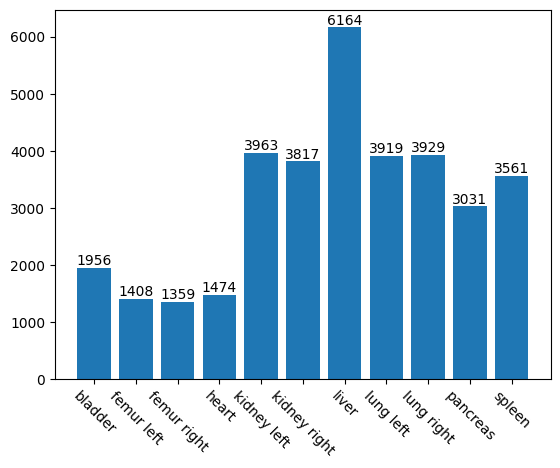

In [7]:
show_dist(train_dataset)

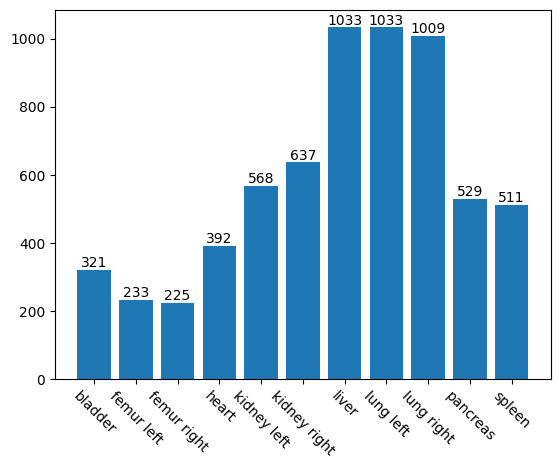

In [8]:
show_dist(valid_dataset)

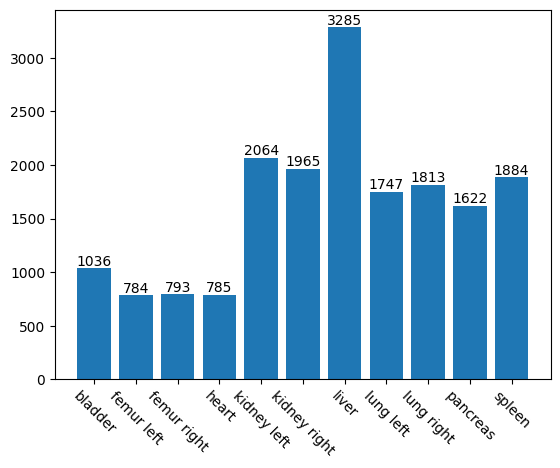

In [9]:
show_dist(test_dataset)

In [10]:
train_loader = DataLoader(train_dataset, shuffle =  True, batch_size = BATCH_SIZE)
valid_loader = DataLoader(valid_dataset, shuffle = False, batch_size = BATCH_SIZE)
test_loader  = DataLoader(test_dataset , shuffle = False, batch_size = 1)

In [11]:
def show_images(loader, k = 3):
    
    sample         = next(iter(loader))
    images, labels = sample
    
    random_idx     = random.sample(
                                    [idx for idx in range(images.shape[0])],
                                    k = k
                                 )
    _, ax          = plt.subplots(1, k)
    for idx, rand in enumerate(random_idx):
        
        ax[idx].imshow(to_numpy(images[rand]), cmap = 'gray')
        ax[idx].set_title(f'label : {idx2label[labels[idx].item()]}')
        ax[idx].axis(False)

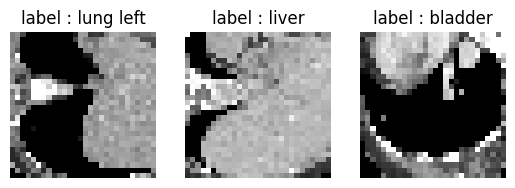

In [12]:
show_images(train_loader)

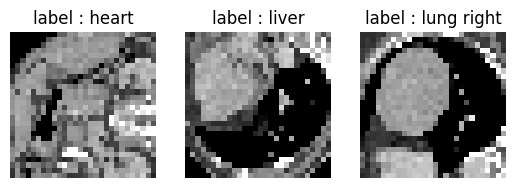

In [13]:
show_images(valid_loader)

In [14]:
class OrganNet(nn.Module):
    
    def __init__(self, n_classes):
        
        super(OrganNet, self).__init__()
        
        self.conv1   = self.ConvBlock( 1, 16, 3)
        self.conv2   = self.ConvBlock(16, 16, 3)
        self.conv3   = self.ConvBlock(16, 64, 3)
        self.conv4   = self.ConvBlock(64, 64, 3)
        self.conv5   = self.ConvBlock(64, 64, 3, 1)
        self.pooling = nn.MaxPool2d(kernel_size = 2, stride = 2)
        self.linear  = self.LinearBlock(64, n_classes)
        
        
    
    def ConvBlock(self, in_feats, out_feats, kernel = 3, padding = None):
            
        Conv2d = nn.Conv2d(in_feats, out_feats, kernel_size = kernel) \
                 if padding == None else nn.Conv2d(in_feats, out_feats, kernel_size = kernel, padding = padding)
        
        layers = nn.Sequential(
                    Conv2d,
                    nn.BatchNorm2d(out_feats),
                    nn.ReLU()
                )
        
        return layers
    
    
    def LinearBlock(self, in_feats, n_classes):
        
        layers = nn.Sequential(
                    nn.Linear(in_feats * 4 * 4, 128),
                    nn.ReLU(),
                    nn.Linear(128, 128),
                    nn.ReLU(),
                    nn.Linear(128, n_classes)
                )
        
        return layers
    

    def forward(self, x):
        
        x = self.conv1(x)
        x = self.pooling(self.conv2(x))
        x = self.conv3(x)
        x = self.pooling(self.conv4(x))
        
        x = x.view(x.size(0), -1)
        x = self.linear(x)
        
        return x

In [15]:
model = OrganNet(n_classes = len(idx2label.keys())).to(DEVICE)
dummy = torch.tensor(np.zeros((1, 1, 28, 28),  dtype = np.float32)).to(DEVICE)
model(dummy)

tensor([[-0.0033,  0.0325,  0.1123, -0.0374,  0.0945,  0.0371,  0.0703, -0.0094,
         -0.0730,  0.0466,  0.0556]], device='cuda:1',
       grad_fn=<AddmmBackward0>)

In [16]:
train_count = [cnt[1] for cnt in lb_counter(train_dataset)]
alpha       = [1 - cnt / sum(train_count) for cnt in train_count]

criterion   = FocalLoss(alpha = alpha, gamma = 2)
# criterion = nn.CrossEntropyLoss()

In [17]:
optimizer   = optim.Adam(params       = model.parameters(), 
                         lr           = INIT_LR,
                         weight_decay = DECAY)

history          = {}
history['train'] = {'loss' : [], 'accuracy' : [], 'f1' : []}
history['valid'] = {'loss' : [], 'accuracy' : [], 'f1' : []}

In [18]:
to_list = lambda tensor: tensor.detach().cpu().numpy().tolist()

def train(model, loader, optimizer):
    
    total_loss = 0
    correct    = 0
    
    gt, predicted  = [], []
    history_       = history['train']
    
    model.train()
    for image, label in tqdm(train_loader):
        
        image    = image.float().to(DEVICE)
        label    = label.to(DEVICE).squeeze().long()
        outputs  = model(image)
        _, preds = torch.max(outputs, 1)
        loss     = criterion(outputs, label)
        
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        
        total_loss += loss.item()
        correct    += torch.sum(preds == label.data)
        predicted  += to_list(preds)
        gt         += to_list(label)
        
    
    avg_loss = total_loss / len(loader)
    accuracy =    correct / (len(loader) * BATCH_SIZE)
    accuracy = float(accuracy.detach().cpu().numpy())
    f1       = f1_score(gt, predicted, average = 'weighted')
    
    print(f'[TRAIN] loss : {avg_loss:.2f} | accuracy : {accuracy:.2f} | f1 score : {f1:.2f}')
    history_['loss'].append(avg_loss)
    history_['accuracy'].append(accuracy)
    history_['f1'].append(f1)
    
    
def valid(model, loader):
    
    total_loss, correct =  0, 0
    gt, predicted       = [], []
    history_            = history['valid']
    
    model.eval()
    
    with torch.no_grad():
        
        for image, label in tqdm(valid_loader):
            
            image    = image.float().to(DEVICE)
            label    = label.to(DEVICE).squeeze().long()
            outputs  = model(image)
            _, preds = torch.max(outputs, 1)
            loss     = criterion(outputs, label)
            
            total_loss += loss.item()
            correct    += torch.sum(preds == label.data)
            
            predicted  += to_list(preds)
            gt         += to_list(label)
            
        
    avg_loss = total_loss / len(loader)
    accuracy =    correct / (len(loader) * BATCH_SIZE)
    accuracy = float(accuracy.detach().cpu().numpy())
    f1       = f1_score(gt, predicted, average = 'weighted')

    print(f'[VALID] loss : {avg_loss:.2f} | accuracy : {accuracy:.2f} | f1 score : {f1:.2f}')
    history_['loss'].append(avg_loss)
    history_['accuracy'].append(accuracy)
    history_['f1'].append(f1)
    
    return f1


def run(model, criterion, train_loader, valid_loader):
    
    early_stopping_cnt = 0
    best_f1            = -1
    
    for epoch in range(EPOCHS):
        
        print(f'[{epoch + 1} / {EPOCHS}]')
        train(model, train_loader, optimizer)
        f1 = valid(model, valid_loader)
        
        if f1 > best_f1:
            
            os.makedirs('models/', exist_ok = True)
            best_f1 = f1
            early_stopping_cnt = 0
            
            torch.save(model, 'models/best_model.pt')
            print(f'save model with f1 : {f1:.2f}')
            
        
        else:
            early_stopping_cnt += 1
            if early_stopping_cnt >= EARLY_STOPING:
                print(f'Training Stopped by Early stopping counter : {early_stopping_cnt}')
                break

In [19]:
run(model, criterion, train_loader, valid_loader)

[1 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 87.80it/s]


[TRAIN] loss : 0.37 | accuracy : 0.68 | f1 score : 0.67


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 158.41it/s]


[VALID] loss : 0.26 | accuracy : 0.73 | f1 score : 0.73
save model with f1 : 0.73
[2 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 88.26it/s]


[TRAIN] loss : 0.17 | accuracy : 0.80 | f1 score : 0.80


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 161.27it/s]


[VALID] loss : 0.17 | accuracy : 0.81 | f1 score : 0.81
save model with f1 : 0.81
[3 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 88.67it/s]


[TRAIN] loss : 0.13 | accuracy : 0.84 | f1 score : 0.84


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 165.01it/s]


[VALID] loss : 0.20 | accuracy : 0.80 | f1 score : 0.80
[4 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 88.28it/s]


[TRAIN] loss : 0.10 | accuracy : 0.86 | f1 score : 0.86


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 124.84it/s]


[VALID] loss : 0.18 | accuracy : 0.82 | f1 score : 0.82
save model with f1 : 0.82
[5 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 88.44it/s]


[TRAIN] loss : 0.09 | accuracy : 0.88 | f1 score : 0.88


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 163.17it/s]


[VALID] loss : 0.13 | accuracy : 0.83 | f1 score : 0.84
save model with f1 : 0.84
[6 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 87.90it/s]


[TRAIN] loss : 0.08 | accuracy : 0.89 | f1 score : 0.89


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 165.10it/s]


[VALID] loss : 0.20 | accuracy : 0.81 | f1 score : 0.80
[7 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 89.93it/s]


[TRAIN] loss : 0.06 | accuracy : 0.91 | f1 score : 0.91


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 162.14it/s]


[VALID] loss : 0.20 | accuracy : 0.83 | f1 score : 0.83
[8 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 88.84it/s]


[TRAIN] loss : 0.06 | accuracy : 0.91 | f1 score : 0.91


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 166.14it/s]


[VALID] loss : 0.15 | accuracy : 0.86 | f1 score : 0.86
save model with f1 : 0.86
[9 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 88.51it/s]


[TRAIN] loss : 0.06 | accuracy : 0.91 | f1 score : 0.92


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 164.47it/s]


[VALID] loss : 0.14 | accuracy : 0.85 | f1 score : 0.84
[10 / 10]


  0%|          | 0/541 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 541/541 [00:06<00:00, 85.57it/s]


[TRAIN] loss : 0.05 | accuracy : 0.93 | f1 score : 0.93


  0%|          | 0/102 [00:00<?, ?it/s]/home/jovyan/NVIDIA_CUDA-11.1_Samples/TIL/AI_study/CV/MIA/misc/FocalLoss.py:34: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  log_pt = F.log_softmax(input)
100%|██████████| 102/102 [00:00<00:00, 163.00it/s]

[VALID] loss : 0.22 | accuracy : 0.81 | f1 score : 0.82


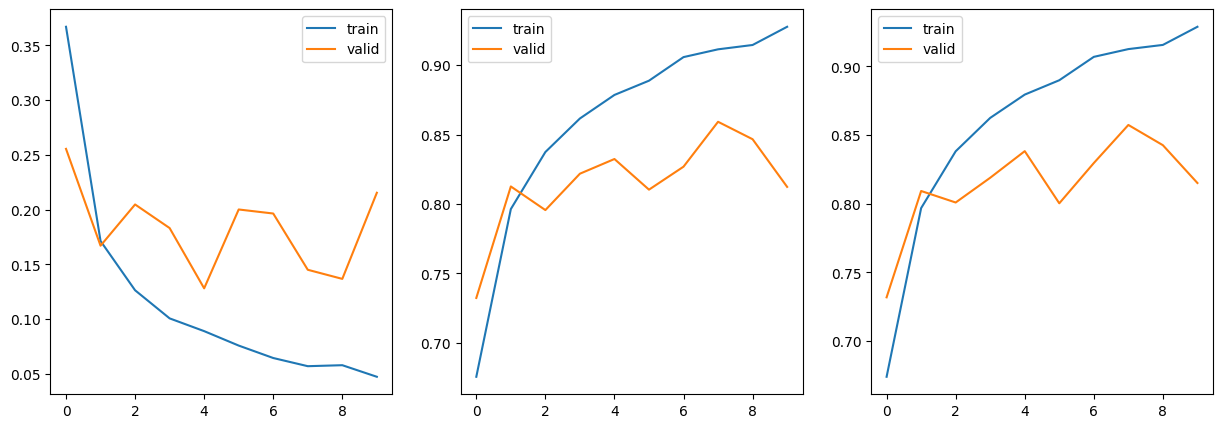

In [20]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for idx, metric in enumerate(['loss', 'accuracy', 'f1']):
    
    ax[idx].plot(history['train'][metric], label = 'train')
    ax[idx].plot(history['valid'][metric], label = 'valid')
    ax[idx].legend()

In [21]:
def inference(model, loader):
    
    pred, gt = [], []
    model.eval()
    
    with torch.no_grad():
        
        for image, label in tqdm(loader):
            
            image    = image.float().to(DEVICE)
            label    = label.to(DEVICE).squeeze().long()
            outputs  = model(image)
            _, preds = torch.max(outputs, 1)
            
            pred.append(preds.detach().cpu().numpy()[0])
            gt.append(label.detach().cpu().numpy())
            
            
    return pred, gt

In [22]:
pred, gt = inference(model, test_loader)
print(classification_report(pred, gt))
print(f'accuracy : {accuracy_score(pred, gt):.2f}')
print(f'f1 score : {f1_score(pred, gt, average = "weighted"):.2f}')

100%|██████████| 17778/17778 [00:16<00:00, 1067.40it/s]

              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1102
           1       0.40      0.51      0.45       610
           2       0.55      0.50      0.52       885
           3       0.78      0.92      0.84       663
           4       0.53      0.51      0.52      2121
           5       0.56      0.51      0.53      2148
           6       0.70      0.93      0.80      2495
           7       0.90      0.69      0.78      2294
           8       0.59      0.93      0.72      1155
           9       0.96      0.52      0.68      2985
          10       0.55      0.79      0.65      1320

    accuracy                           0.67     17778
   macro avg       0.67      0.69      0.67     17778
weighted avg       0.71      0.67      0.67     17778

accuracy : 0.67
f1 score : 0.67


In [23]:
model = OrganNet(n_classes = len(idx2label.keys())).to(DEVICE)
dummy = torch.tensor(np.zeros((1, 1, 28, 28),  dtype = np.float32)).to(DEVICE)
model(dummy)

tensor([[-0.0561,  0.0679, -0.0183,  0.0605, -0.0162,  0.0590,  0.0070, -0.0392,
          0.0723, -0.0163,  0.0585]], device='cuda:1',
       grad_fn=<AddmmBackward0>)

In [24]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(params         = model.parameters(), 
                         lr           = INIT_LR,
                         weight_decay = DECAY)

history1        = history
history          = {}
history['train'] = {'loss' : [], 'accuracy' : [], 'f1' : []}
history['valid'] = {'loss' : [], 'accuracy' : [], 'f1' : []}

In [25]:
run(model, criterion, train_loader, valid_loader)

[1 / 10]


100%|██████████| 541/541 [00:05<00:00, 90.34it/s]


[TRAIN] loss : 0.77 | accuracy : 0.68 | f1 score : 0.68


100%|██████████| 102/102 [00:00<00:00, 163.63it/s]


[VALID] loss : 0.75 | accuracy : 0.70 | f1 score : 0.70
save model with f1 : 0.70
[2 / 10]


100%|██████████| 541/541 [00:06<00:00, 89.93it/s]


[TRAIN] loss : 0.43 | accuracy : 0.82 | f1 score : 0.82


100%|██████████| 102/102 [00:00<00:00, 158.50it/s]


[VALID] loss : 0.51 | accuracy : 0.80 | f1 score : 0.80
save model with f1 : 0.80
[3 / 10]


100%|██████████| 541/541 [00:06<00:00, 87.73it/s]


[TRAIN] loss : 0.32 | accuracy : 0.86 | f1 score : 0.86


100%|██████████| 102/102 [00:00<00:00, 165.75it/s]


[VALID] loss : 0.42 | accuracy : 0.84 | f1 score : 0.84
save model with f1 : 0.84
[4 / 10]


100%|██████████| 541/541 [00:06<00:00, 89.83it/s]


[TRAIN] loss : 0.26 | accuracy : 0.89 | f1 score : 0.89


100%|██████████| 102/102 [00:00<00:00, 166.20it/s]


[VALID] loss : 0.39 | accuracy : 0.85 | f1 score : 0.85
save model with f1 : 0.85
[5 / 10]


100%|██████████| 541/541 [00:06<00:00, 90.08it/s]


[TRAIN] loss : 0.22 | accuracy : 0.90 | f1 score : 0.91


100%|██████████| 102/102 [00:00<00:00, 164.69it/s]


[VALID] loss : 0.53 | accuracy : 0.82 | f1 score : 0.82
[6 / 10]


100%|██████████| 541/541 [00:05<00:00, 90.87it/s]


[TRAIN] loss : 0.20 | accuracy : 0.92 | f1 score : 0.92


100%|██████████| 102/102 [00:00<00:00, 169.94it/s]


[VALID] loss : 0.50 | accuracy : 0.84 | f1 score : 0.83
[7 / 10]


100%|██████████| 541/541 [00:06<00:00, 90.15it/s]


[TRAIN] loss : 0.16 | accuracy : 0.93 | f1 score : 0.93


100%|██████████| 102/102 [00:00<00:00, 132.02it/s]


[VALID] loss : 0.47 | accuracy : 0.84 | f1 score : 0.84
[8 / 10]


100%|██████████| 541/541 [00:06<00:00, 90.07it/s]


[TRAIN] loss : 0.15 | accuracy : 0.94 | f1 score : 0.94


100%|██████████| 102/102 [00:00<00:00, 165.70it/s]


[VALID] loss : 0.38 | accuracy : 0.87 | f1 score : 0.88
save model with f1 : 0.88
[9 / 10]


100%|██████████| 541/541 [00:06<00:00, 90.10it/s]


[TRAIN] loss : 0.13 | accuracy : 0.94 | f1 score : 0.94


100%|██████████| 102/102 [00:00<00:00, 164.63it/s]


[VALID] loss : 0.52 | accuracy : 0.86 | f1 score : 0.85
[10 / 10]


100%|██████████| 541/541 [00:05<00:00, 91.21it/s]


[TRAIN] loss : 0.12 | accuracy : 0.95 | f1 score : 0.95


100%|██████████| 102/102 [00:00<00:00, 165.58it/s]

[VALID] loss : 0.47 | accuracy : 0.86 | f1 score : 0.86


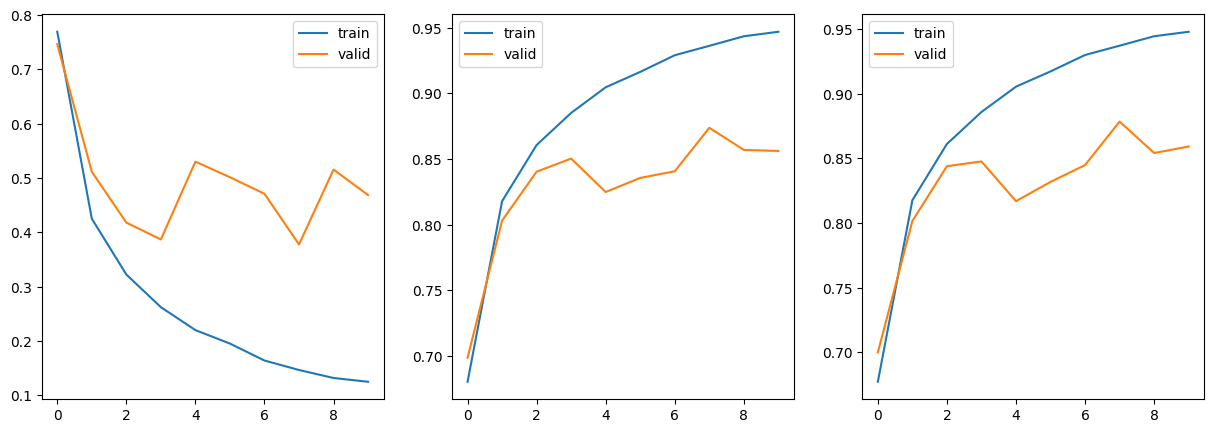

In [26]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

for idx, metric in enumerate(['loss', 'accuracy', 'f1']):
    
    ax[idx].plot(history['train'][metric], label = 'train')
    ax[idx].plot(history['valid'][metric], label = 'valid')
    ax[idx].legend()

In [27]:
pred, gt = inference(model, test_loader)
print(classification_report(pred, gt))
print(f'accuracy : {accuracy_score(pred, gt):.2f}')
print(f'f1 score : {f1_score(pred, gt, average = "weighted"):.2f}')

100%|██████████| 17778/17778 [00:16<00:00, 1062.45it/s]


              precision    recall  f1-score   support

           0       0.84      0.88      0.86       989
           1       0.54      0.48      0.51       882
           2       0.43      0.44      0.44       778
           3       0.72      0.93      0.81       606
           4       0.49      0.56      0.52      1799
           5       0.61      0.56      0.58      2166
           6       0.98      0.86      0.92      3730
           7       0.90      0.79      0.84      2004
           8       0.72      0.88      0.79      1486
           9       0.81      0.87      0.84      1507
          10       0.76      0.78      0.77      1831

    accuracy                           0.75     17778
   macro avg       0.71      0.73      0.72     17778
weighted avg       0.76      0.75      0.75     17778

accuracy : 0.75
f1 score : 0.75


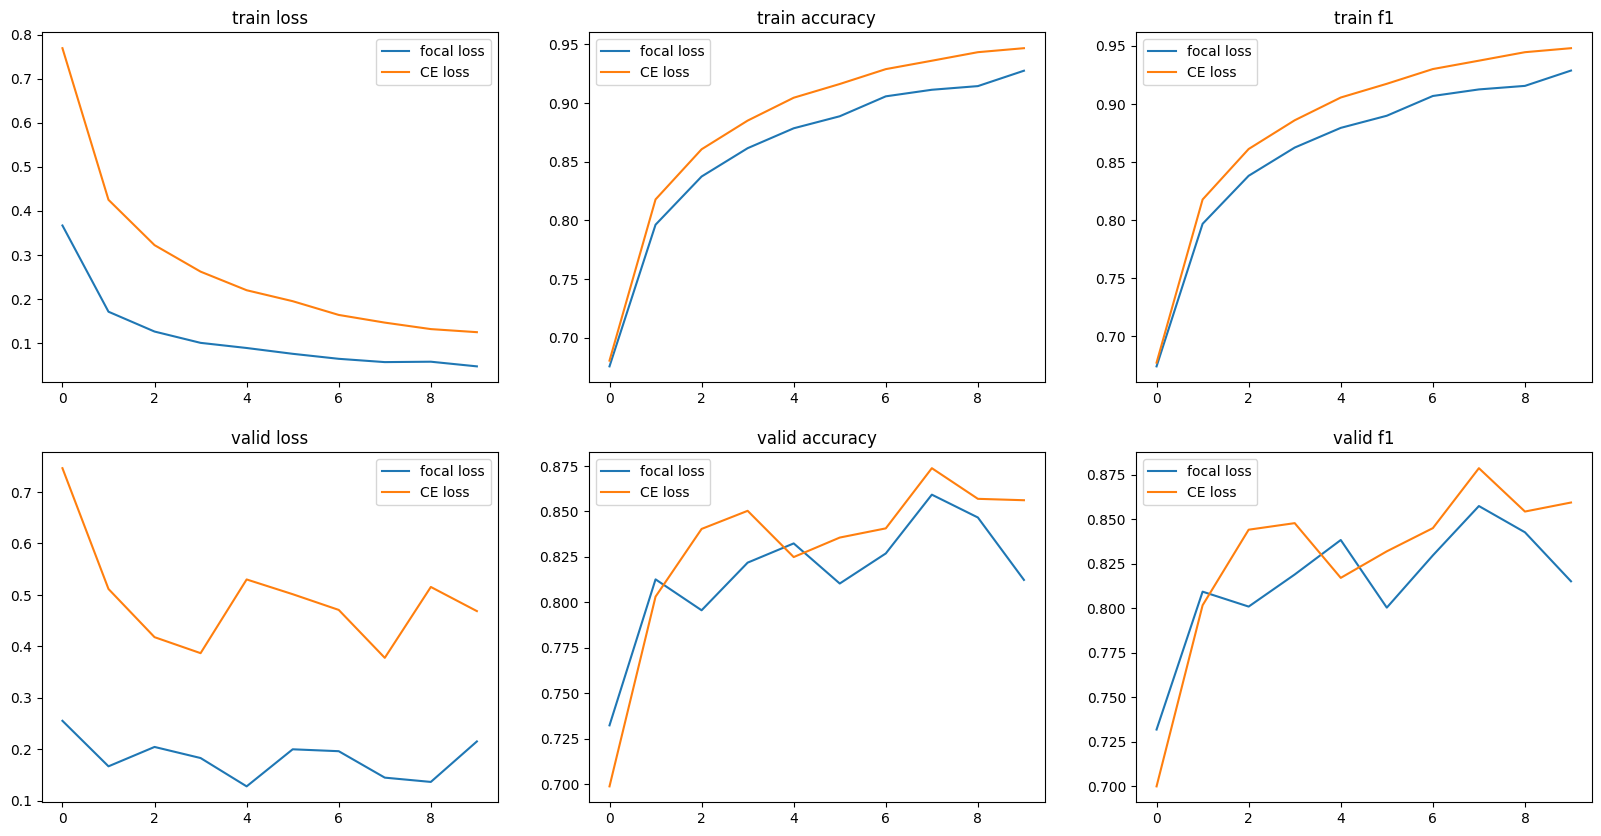

In [28]:
_, ax = plt.subplots(2, 3, figsize = (20, 10))

for odx, dtype in enumerate(['train', 'valid']):
    
    for idx, metric in enumerate(['loss', 'accuracy', 'f1']):
        
        ax[odx][idx].plot(history1[dtype][metric], label = 'focal loss')
        ax[odx][idx].plot(history[dtype][metric],  label = 'CE loss')
        ax[odx][idx].set_title(f'{dtype} {metric}')
        ax[odx][idx].legend()